## Don't rename! Don't delete the output of the cells! This notebook is actually to debug whether the failure comes from the abrupt changes from discharge to charge, which it turns out that increasing mesh poitns doesn't help and Siomn cited from O'Regan paper that such voltage changes are within normal range and shouldn't be the problem!

In [12]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize,sys
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
########################     Global settings!!!
rows_per_file = 1;  Scan_end_end = 6;
purpose_i = "Full_Exp_9_3Ts"

On_HPC =  False  
Runshort  =   True                    # a long run or a quick test



if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters


if On_HPC:                          # Run on HPC
    Path_csv = f"InputData/{purpose_i}/" 
    Path_NiallDMA = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_NiallDMA = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
    Para_file = BasicPath+f'/Get_Random_sets2/{purpose_i}/'+para_csv
    
if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);
# import all functions 
from Fun_P2 import * 

# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)


pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 1


In [14]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode surface potential difference [V]",
    "CCend SEI film overpotential [V]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Negative electrode surface potential difference [V]",
    "CDend SEI film overpotential [V]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [15]:
print(Para_dict_list[0]) # initial mesh: [5,5,5,60,20]
# Para_dict_list[0][ 'Mesh list'] = '[5,5,5,60,20]'
# run record
# 1-'[10,10,10,100,20]' - 1 hour every 26 ageing cycles

{'Scan No': 4, 'Exp No.': 9, 'Ageing temperature': 25.0, 'Mesh list': '[5,5,5,60,20]', 'Inner SEI lithium interstitial diffusivity [m2.s-1]': 9.81e-18, 'Dead lithium decay constant [s-1]': 1e-07, 'Lithium plating kinetic rate constant [m.s-1]': 1e-10, 'Negative electrode LAM constant proportional term [s-1]': 2.84e-09, 'Positive electrode LAM constant proportional term [s-1]': 2.98e-18, 'Negative electrode cracking rate': 5.29e-25, 'Outer SEI partial molar volume [m3.mol-1]': 5.22e-05, 'SEI growth activation energy [J.mol-1]': 10000.0, 'Negative cracking growth activation energy [J.mol-1]': 0.0, 'Negative electrode diffusivity activation energy [J.mol-1]': 17000.0, 'Positive electrode diffusivity activation energy [J.mol-1]': 12000.0, 'Contact resistance [Ohm]': 0.0115, 'Total heat transfer coefficient [W.m-2.K-1]': 20, 'Initial electrolyte excessive amount ratio': 1.1, 'Cycles within RPT': 1, 'RPT temperature': 25, 'Para_Set': 'OKane2023', 'Model option': "{'SEI': 'interstitial-diffus

In [16]:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=True;     Timelimit = int(60*10)
Return_Sol=True;   Check_Small_Time=True; R_from_GITT = False
Runshort = True;   Add_Rest = True
midc_merge,Sol_RPT,Sol_AGE,DeBug_Lists = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout, Timelimit,
    Return_Sol, Check_Small_Time, R_from_GITT,Add_Rest,
) 


Start Now! Scan 4.
Has Overwritten Initial outer SEI thickness [m] to be 6.73e-09 and Negative electrode porosity to be 0.235 to account for initial capacity loss of 0.135 Ah
Scan 4: DryOut = On
Initial electrolyte amount is  5.759780286600199 mL
Scan 4: Spent 2.475 ms on Initialization


At t = 351.087 and h = 5.59983e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish break-in cycle within 2 minutes, 22 seconds
Fail to read Throughput capacity for the 1th time
Scan 4: Finish post-process for break-in cycle within 1.376 s
Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 124.215 and h = 4.28404e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 124.214 and h = 6.80419e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.0 ageing cycles within 44.073 s
Scan 4: Finish post-process for No.1 ageing cycles within 280.872 ms


At t = 358.43 and h = 1.43122e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 347.122 and h = 1.91989e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.1 RPT cycles within 2 minutes, 3 seconds
Scan 4: Finish post-process for No.1 RPT cycles within 943.462 ms


At t = 113.571 and h = 4.65448e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.57 and h = 1.42335e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 113.571 and h = 8.60819e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.5706 and h = 5.20357e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.1 ageing cycles within 45.108 s
Scan 4: Finish post-process for No.2 ageing cycles within 197.386 ms


At t = 354.5 and h = 1.12154e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 343.242 and h = 3.23071e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.2 RPT cycles within 2 minutes, 11 seconds
Scan 4: Finish post-process for No.2 RPT cycles within 762.723 ms
Scan 4: Getting extra variables within 191.800 us
Scan 4: Finish all plots within 6.029 s
Successfully create a excel file
Scan 4: Successfully save json file!
Scan 4: Successfully save mat file!
Scan 4: Try saving within 30.616 ms
Succeed doing something in 8 minutes, 15 seconds
This is the end of No. 4  scan


In [27]:
# try more mesh points in r_n
Para_dict_list[0][ 'Mesh list'] = '[5,5,5,100,20]'
midc_merge_rn100,Sol_RPT_rn100,Sol_AGE_rn100,DeBug_Lists_rn100 = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout, Timelimit,
    Return_Sol, Check_Small_Time, R_from_GITT,Add_Rest,
) 

Start Now! Scan 4.
Has Overwritten Initial outer SEI thickness [m] to be 6.73e-09 and Negative electrode porosity to be 0.235 to account for initial capacity loss of 0.135 Ah
Scan 4: DryOut = On
Initial electrolyte amount is  5.759780286600199 mL
Scan 4: Spent 1.033 ms on Initialization


At t = 349.509 and h = 2.5228e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish break-in cycle within 3 minutes, 5 seconds
Fail to read Throughput capacity for the 1th time
Scan 4: Finish post-process for break-in cycle within 1.514 s
Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 122.801 and h = 4.64777e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.801 and h = 4.46416e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.0 ageing cycles within 1 minute, 3 seconds
Scan 4: Finish post-process for No.1 ageing cycles within 346.312 ms


At t = 356.835 and h = 2.09405e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 345.553 and h = 2.21455e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.1 RPT cycles within 2 minutes, 58 seconds
Scan 4: Finish post-process for No.1 RPT cycles within 995.523 ms


At t = 112.176 and h = 4.06871e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.176 and h = 5.00582e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.176 and h = 4.75449e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.1763 and h = 7.404e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.1 ageing cycles within 1 minute, 4 seconds
Scan 4: Finish post-process for No.2 ageing cycles within 224.065 ms


At t = 352.916 and h = 1.59518e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 341.684 and h = 1.71422e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.2 RPT cycles within 2 minutes, 56 seconds
Scan 4: Finish post-process for No.2 RPT cycles within 981.328 ms
Scan 4: Getting extra variables within 280.200 us
Scan 4: Finish all plots within 6.775 s
Successfully create a excel file
Scan 4: Successfully save json file!
Scan 4: Successfully save mat file!
Scan 4: Try saving within 38.929 ms
Succeed doing something in 11 minutes, 17 seconds
This is the end of No. 4  scan


In [32]:
Para_dict_list[0][ 'Mesh list'] = '[5,5,5,150,20]'
midc_merge_rn200,Sol_RPT_rn200,Sol_AGE_rn200,DeBug_Lists_rn200 = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout, Timelimit,
    Return_Sol, Check_Small_Time, R_from_GITT,Add_Rest,
) 

Start Now! Scan 4.
Has Overwritten Initial outer SEI thickness [m] to be 6.73e-09 and Negative electrode porosity to be 0.235 to account for initial capacity loss of 0.135 Ah
Scan 4: DryOut = On
Initial electrolyte amount is  5.759780286600199 mL
Scan 4: Spent 986.700 us on Initialization


At t = 348.927 and h = 1.69803e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish break-in cycle within 4 minutes, 43 seconds
Fail to read Throughput capacity for the 1th time
Scan 4: Finish post-process for break-in cycle within 2.101 s
Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 122.243 and h = 9.82632e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 122.243 and h = 2.8826e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.0 ageing cycles within 1 minute, 37 seconds
Scan 4: Finish post-process for No.1 ageing cycles within 361.016 ms


At t = 356.247 and h = 2.20635e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 344.974 and h = 6.51014e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.1 RPT cycles within 4 minutes, 41 seconds
Scan 4: Finish post-process for No.1 RPT cycles within 1.275 s


At t = 111.623 and h = 1.53588e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.624 and h = 1.07224e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.623 and h = 1.15448e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.6236 and h = 5.61797e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 4: Finish for No.1 ageing cycles within 1 minute, 44 seconds
Scan 4: Finish post-process for No.2 ageing cycles within 337.690 ms


At t = 352.33 and h = 1.05182e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 341.107 and h = 1.87964e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 4: Finish for No.2 RPT cycles within 4 minutes, 54 seconds
Scan 4: Finish post-process for No.2 RPT cycles within 1.313 s
Scan 4: Getting extra variables within 164.800 us
Scan 4: Finish all plots within 7.214 s
Successfully create a excel file
Scan 4: Successfully save json file!
Scan 4: Successfully save mat file!
Scan 4: Try saving within 29.077 ms
Succeed doing something in 17 minutes, 52 seconds
This is the end of No. 4  scan


### debug part

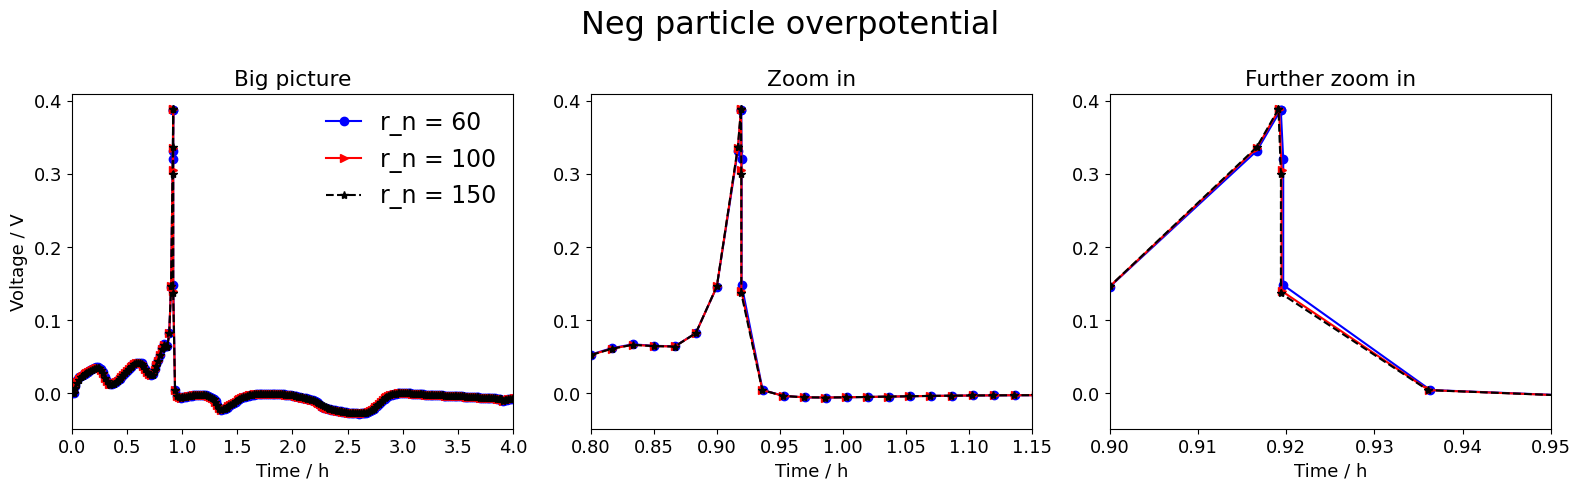

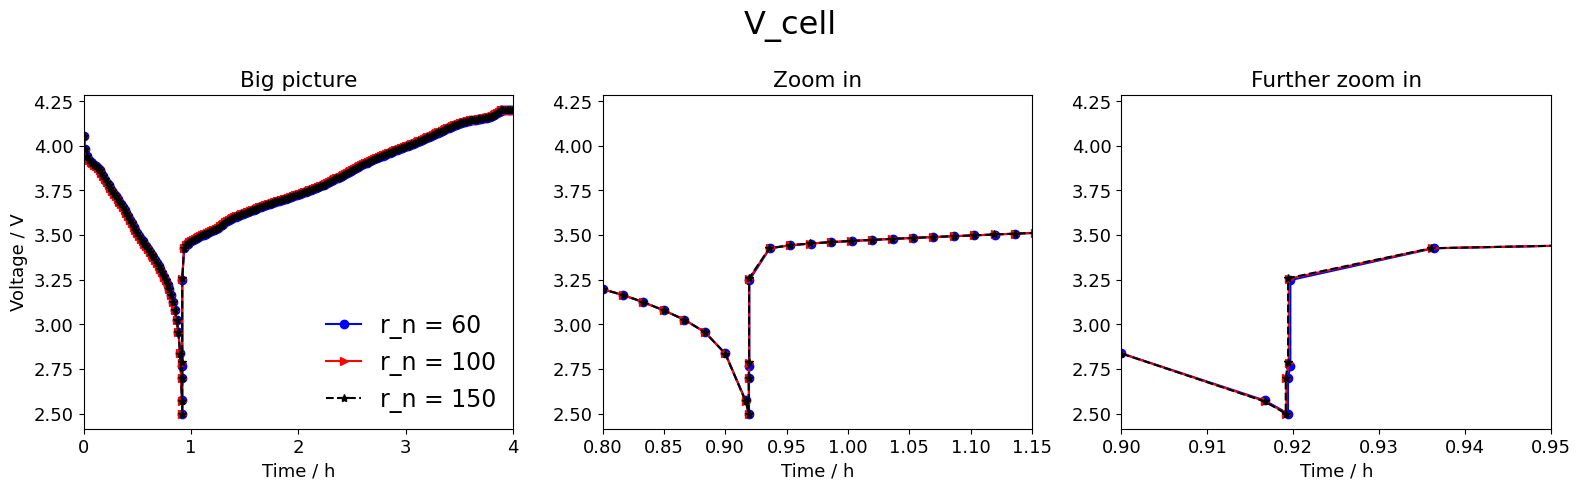

In [33]:
def Plot_compare_sols(Fig_title,key):
    fig, Axs = plt.subplots(1,3, figsize=(16,5),tight_layout=True)
    Titles = ["r_n = 60", "r_n = 100", "r_n = 150"]
    for i in range(3):
        axs = Axs[i]
        axs.plot(
            Sol_AGE[1].cycles[0]["Time [h]"].entries,
            Sol_AGE[1].cycles[0][key].entries, 
            color='b',   linestyle='-',marker = 'o',
            label=Titles[0])

        axs.plot(
            Sol_AGE_rn100[1].cycles[0]["Time [h]"].entries,
            Sol_AGE_rn100[1].cycles[0][key].entries, 
            color='r',   linestyle='-',marker = '>',
            label=Titles[1])
        
        axs.plot(
            Sol_AGE_rn200[1].cycles[0]["Time [h]"].entries,
            Sol_AGE_rn200[1].cycles[0][key].entries, 
            color='k',   linestyle='--',marker = '*',
            label=Titles[2])
        axs.set_xlabel("Time / h")
        
    Axs[0].set_xlim(0,4)
    Axs[1].set_xlim(0.8,1.15)
    
    Axs[2].set_xlim(0.9,0.95)
    
    Axs[0].legend(prop={'family':'DejaVu Sans','size':fs+4},
            frameon=False,markerscale=1,borderpad=0.2,
            handlelength=1.5,columnspacing=1)
    #axs.set_ylim(2.45,3.7)
    Axs[0].set_ylabel("Voltage / V")
    Axs[0].set_title("Big picture")
    Axs[1].set_title("Zoom in")
    Axs[2].set_title("Further zoom in")
    fig.suptitle(Fig_title, fontsize=fs+10)
    #Axs[1].set_ylim(2.45,3.6)
    #Axs[2].set_ylim(2.45,3.6)
    return 

Plot_compare_sols(
    "Neg particle overpotential"    ,
    "Battery negative particle concentration overpotential [V]"      )
Plot_compare_sols(
    "V_cell"    ,
    "Terminal voltage [V]"      )

In [17]:
[DeBug_List_RPT,DeBug_List_AGE] = DeBug_Lists
[
    Model, Model_new, Call_RPT, Simnew,   Sol , Sol_new, Para_update, ModelExperiment, 
    Update_Cycles,Temper_i ,mesh_list,submesh_strech, var_pts,
    submesh_types,  list_short, dict_short, 
] = DeBug_List_AGE

ValueError: not enough values to unpack (expected 16, got 5)

In [ ]:
class RioCallback(pb.callbacks.Callback):
    def __init__(self, logfile=None):
        self.logfile = logfile
        self.success  = True
        if logfile is None:
            # Use pybamm's logger, which prints to command line
            self.logger = pb.logger
        else:
            # Use a custom logger, this will have its own level so set it to the same
            # level as the pybamm logger (users can override this)
            self.logger = pb.get_new_logger(__name__, logfile)
            self.logger.setLevel(pb.logger.level)
    
    def on_experiment_error(self, logs):
        self.success  = False
    def on_experiment_infeasible(self, logs):
        self.success  = False
Call_Age = RioCallback()  
Simnew_2 = pb.Simulation(
    Model_new,
    experiment = ModelExperiment, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_2 = Simnew_2.solve(
    calc_esoh=False,
    save_at_cycles = Update_Cycles,
    callbacks=Call_Age,)

In [ ]:
exp_AGE_text_3 = [(
    "Discharge at 1C until 2.6V", 
    "Discharge at 1C until 2.5V (3 seconds period)", 
    "Charge at 0.3C until 3.3V (3 seconds period)",
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",
    ),  ]  # *  78
Experiment_Long_3   = pb.Experiment( exp_AGE_text_3 * Update_Cycles  )  
Simnew_3 = pb.Simulation(
    Model_new,
    experiment = Experiment_Long_3, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_3 = Simnew_3.solve(
    calc_esoh=False,
    save_at_cycles = Update_Cycles,
    callbacks=Call_Age,)

In [ ]:
def Run_Model_Base_On_Last_Solution_part(Sol_new,Sol,Update_Cycles,Call_Age):
    i_try = 0
    while i_try<3:
        try:
            getSth2 = Sol_new['Throughput capacity [A.h]'].entries[-1]
        except:
            i_try += 1
            print(f"Fail to read Throughput capacity for the {i_try}th time")
        else:
            break
    i_try = 0
    while i_try<3:
        try:
            getSth = Sol['Throughput capacity [A.h]'].entries[-1]
        except:
            i_try += 1
            print(f"Fail to read Throughput capacity for the {i_try}th time")
        else:
            break
    # update 23-11-16 change method to get throughput capacity:
    # # (1) add old ones, as before; (2): change values of the last one
    Sol_new['Throughput capacity [A.h]'].entries += getSth
    if not Update_Cycles == 1: # the solution is imcomplete in this case
        cyc_number = len(Sol_new.cycles)
        thr_1st = np.trapz(
            abs(Sol_new.cycles[0]["Current [A]"].entries), 
            Sol_new.cycles[0]["Time [h]"].entries) # in A.h
        thr_end = np.trapz(
            abs(Sol_new.cycles[-1]["Current [A]"].entries), 
            Sol_new.cycles[-1]["Time [h]"].entries) # in A.h
        thr_tot = (thr_1st+thr_end) / 2 * cyc_number
    else:
        thr_tot = abs(
            Sol_new['Throughput capacity [A.h]'].entries[-1] - 
            Sol_new['Throughput capacity [A.h]'].entries[0]  )
    Sol_new['Throughput capacity [A.h]'].entries[-1] = getSth + thr_tot # only the last one is true
    DeBug_List = "Empty"
    Result_list = [Model_new, Sol_new,Call_Age,DeBug_List]
    return Result_list
Result_list_AGE_2 = Run_Model_Base_On_Last_Solution_part(Sol_new_2,Sol,Update_Cycles,Call_Age)
[Model_Dry_2, Sol_Dry_2 , Call_Age_2,DeBug_List_AGE_2 ] = Result_list_AGE_2


In [ ]:
cyc_stp = Sol_new_2.cycles[77]
fig, axs = plt.subplots(1,3, figsize=(12,3.2),tight_layout=True)
axs[0].plot(
    cyc_stp["Time [h]"].entries - cyc_stp["Time [h]"].entries[0],
    cyc_stp["Terminal voltage [V]"].entries, "-o",
    label="Vol")
axs[0].set_xlim(0.7,0.8)
axs[0].set_ylim(2.45,3.5)
axs[1].plot(
    cyc_stp["x [m]"].entries[:,-1],
    cyc_stp["Porosity"].entries[:,-1],
    label="Por")
# "SEI interfacial current density [A.m-2]"
axs[2].plot(
    cyc_stp["x_n [m]"].entries[:,-1],
    cyc_stp["SEI interfacial current density [A.m-2]"].entries[:,-1],
    label="j_SEI")
for i in range(3):
    axs[i].legend()

In [ ]:
print(Sol_new_2.cycles[77].steps[0]["Time [s]"].entries[-2:])
print(Sol_new_2.cycles[77].steps[0]["Terminal voltage [V]"].entries[-2:])

print(Sol_new_2.cycles[77].steps[1]["Time [s]"].entries[0:2])
print(Sol_new_2.cycles[77].steps[1]["Terminal voltage [V]"].entries[0:2])

# 
print(
    Sol_new_2.cycles[77].steps[1]["Time [s]"].entries[0] - 
    Sol_new_2.cycles[77].steps[0]["Time [s]"].entries[-1])
print(
    Sol_new_2.cycles[77].steps[1]["Terminal voltage [V]"].entries[0] - 
    Sol_new_2.cycles[77].steps[0]["Terminal voltage [V]"].entries[-1])

In [ ]:

var3 = [
    "Porosity",
    "Electrolyte concentration [mol.m-3]",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(Sol_new_2.cycles[-1], var3,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
plt.plot(midc_merge["Discharge capacity [A.h]"],"-o") # Cyc_Update_Index
#midc_merge["Cyc_Update_Index"] 
print(midc_merge["Discharge capacity [A.h]"][-2]/midc_merge["Discharge capacity [A.h]"][0]*100)

In [ ]:
# index_exp should be 1~5:
index_exp = 1; Plot_Exp = "haha"
if not index_exp in list(np.arange(1,6)):
    Plot_Exp = False
print(Plot_Exp)

In [ ]:
np.diff(np.array(midc_merge['Throughput capacity [kA.h]'])*1e3)

In [ ]:
plt.plot(Sol_RPT[1]['Throughput capacity [A.h]'].entries)

In [ ]:
print(Sol_RPT[1]['Throughput capacity [A.h]'].entries  - Sol_RPT[1]['Throughput capacity [A.h]'].entries[0] )
print(Sol_RPT[0]['Throughput capacity [A.h]'].entries  - Sol_RPT[0]['Throughput capacity [A.h]'].entries[0] )

In [ ]:

# note: this is only precise for Exp-2, for Exp-3 there might be bigger issue.
def Get_Throughput_cap(sol,save_as_cycle): 
    if save_as_cycle==1:
        thr_tot = (
            sol['Throughput capacity [A.h]'].entries[-1]
            -sol['Throughput capacity [A.h]'].entries[0]) 
    else:
        # Get average of first and last:
        cyc_number = len(sol.cycles)
        thr_1st = np.trapz(
            abs(sol.cycles[0]["Current [A]"].entries), 
            sol.cycles[0]["Time [h]"].entries) # in A.h
        thr_end = np.trapz(
            abs(sol.cycles[-1]["Current [A]"].entries), 
            sol.cycles[-1]["Time [h]"].entries) # in A.h
        thr_tot = (thr_1st+thr_end) / 2 * cyc_number
        # print(thr_1st,thr_end,thr_tot)
    return thr_tot
Get_Throughput_cap(Sol_AGE[-1],516)

In [ ]:
Get_Throughput_cap(Sol_RPT[0],1)
Sol_RPT[0]['Throughput capacity [A.h]'].entries

In [ ]:
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1] 
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1]  = 100
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1] 

In [ ]:
plt.plot(Sol_RPT[0]["Time [h]"].entries)

In [ ]:

fig, axs = plt.subplots(3,1,figsize=(6,10),tight_layout=True) 
axs[0].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Terminal voltage [V]"].entries,'-o')
axs[1].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Current [A]"].entries,'-o')
axs[2].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Throughput capacity [A.h]"].entries-Sol_RPT[1]["Throughput capacity [A.h]"].entries[0],'-o')

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Terminal voltage [V]"].entries,'-o')

In [ ]:
(0.7297365+0.5339990778626663)*516
0.7297365*2*518
print(len(Sol_AGE),len(Sol_RPT),)

In [ ]:
def Plot_sol(sol):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Throughput capacity [A.h]"].entries-sol["Throughput capacity [A.h]"].entries[0],'-o')
    thr_cap_1 = sol["Throughput capacity [A.h]"].entries[-1]-sol["Throughput capacity [A.h]"].entries[0]
    thr_cap_2 = np.trapz(abs(sol["Current [A]"].entries), sol["Time [h]"].entries) # in A.h
    print(thr_cap_1,thr_cap_2)
    return thr_cap_1,thr_cap_2
cap_acc = 0
for i in range(2):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[i])
    cap_acc +=  thr_cap_1
for i in range(3):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_RPT[i])
    cap_acc +=  thr_cap_1
print(cap_acc)

In [ ]:
thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[0].cycles[0])
thr_cap_3,thr_cap_4 = Plot_sol(Sol_AGE[0].cycles[-1])
print((thr_cap_1+thr_cap_3)/2*516)

In [ ]:
plt.plot(Sol_RPT[0]["Time [h]"].entries,Sol_RPT[0]["Discharge capacity [A.h]"].entries,'-o')
plt.plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Discharge capacity [A.h]"].entries,'--')
plt.plot(Sol_RPT[2]["Time [h]"].entries,Sol_RPT[2]["Discharge capacity [A.h]"].entries,'--')

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Throughput capacity [A.h]"].entries,'-o')

In [ ]:
# Sol_0[0].cycles[-1]["Negative electrode stoichiometry"].entries
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[0].cycles[-1], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
Sol_0[-2].cycles

In [ ]:
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[-1].cycles[0], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();